# Install Dependencies and Import Required Packages

In [1]:
# !sudo add-apt-repository ppa:openjdk-r/ppa
!sudo apt-get install openjdk-11-jdk
# To Install Oracke JDK varsion 8
# !sudo add-apt-repository ppa:webupd8team/java
# !sudo apt-get install oracle-java8-installer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  openjdk-11-demo openjdk-11-source visualvm
The following NEW packages will be installed:
  openjdk-11-jdk
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,544 kB of archives.
After this operation, 1,595 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openjdk-11-jdk amd64 11.0.14.1+1-0ubuntu1~18.04 [1,544 kB]
Fetched 1,544 kB in 1s (2,135 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 

In [2]:
# !wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !tar xvzf spark-3.1.1-bin-hadoop3.2.tgz
!pip install pyspark
!pip install -q findspark
!pip install pyarrow
try:
  # %tensorflow_version only exists in Colab.
  !pip install  tf-estimator-nightly==2.8.0.dev2021122109
except Exception:
  pass

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 53.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f1a12583b48b235f288585aeb3556c45c083c03cd86791a8b0cab84deef30340
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 462 kB 31.0 MB/s 


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1"


In [4]:
from pyspark.sql.functions import col, pandas_udf, regexp_extract
import io

from tensorflow.keras.applications.imagenet_utils import decode_predictions
import pandas as pd
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pathlib
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt 


findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Importing CIFAR 10 Dataset using Keras Datasets

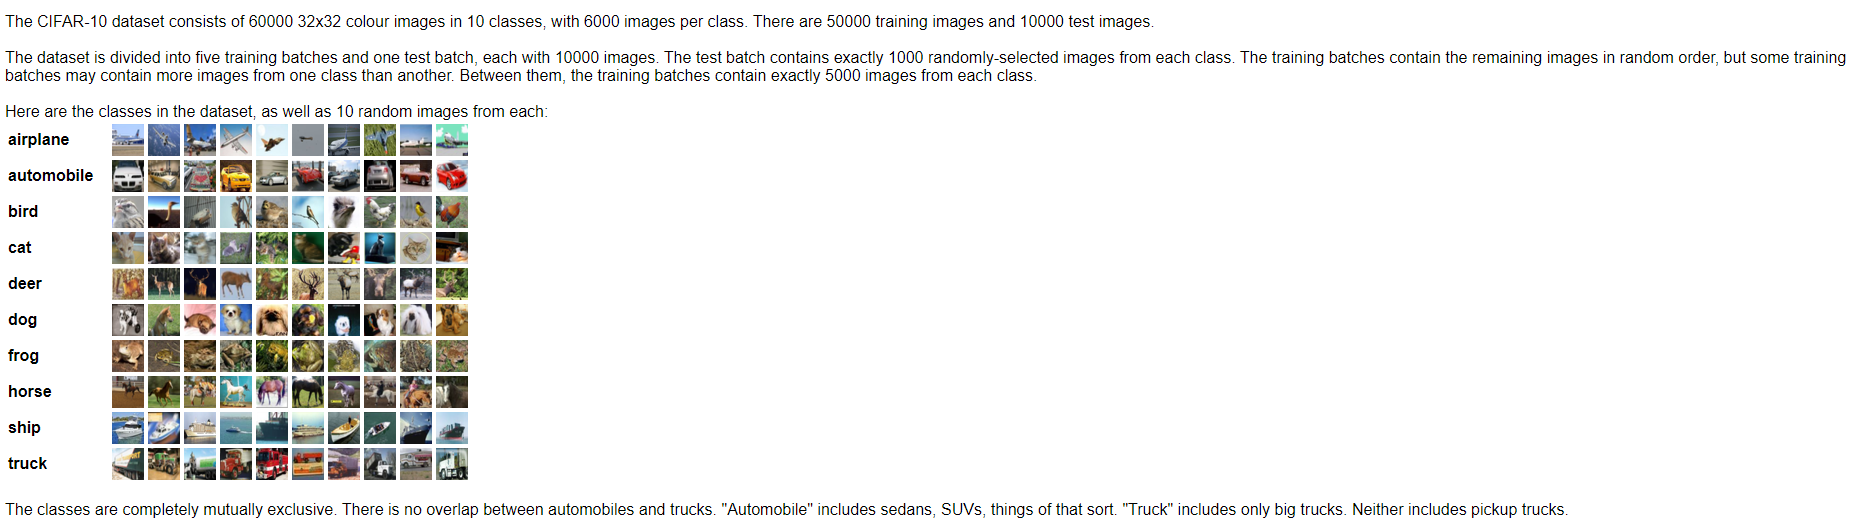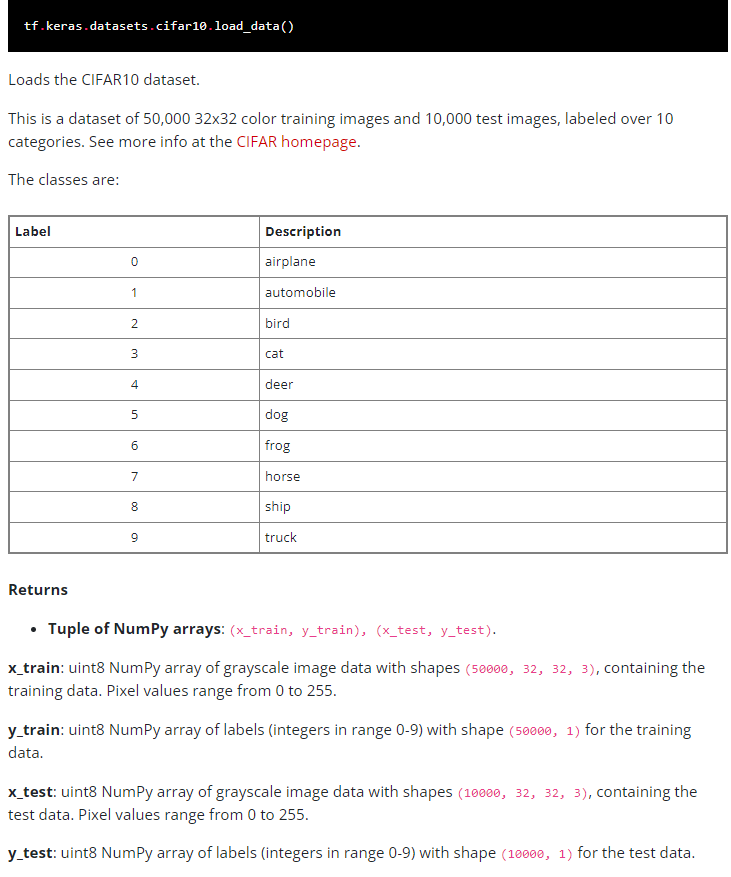

In [5]:
from keras.datasets import cifar10

(X_train,y_train),(X_test,y_test)  =  cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [6]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

In [7]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
# Convert image to bytes
def image_to_byte(image):
  import PIL.Image as Image
  pil_im = Image.fromarray(image)
  b = io.BytesIO()
  pil_im.save(b, 'jpeg')
  im_bytes = b.getvalue()
  return im_bytes

In [9]:
test_df = pd.DataFrame({"content": list(map(image_to_byte, X_test[:25])), "label": list(map(lambda x: labels[int(x)], y_test[:25]))})

In [10]:
test_df

,content,label
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,cat
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,ship
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,ship
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,airplane
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,frog
5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,frog
6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,automobile
7,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,frog
8,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,cat
9,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,automobile


# Creating a Spark Dataframe

In [11]:
df = spark.createDataFrame(test_df, schema=['content', 'label'])

In [12]:
df.show(10)

+--------------------+----------+
|             content|     label|
+--------------------+----------+
|[FF D8 FF E0 00 1...|       cat|
|[FF D8 FF E0 00 1...|      ship|
|[FF D8 FF E0 00 1...|      ship|
|[FF D8 FF E0 00 1...|  airplane|
|[FF D8 FF E0 00 1...|      frog|
|[FF D8 FF E0 00 1...|      frog|
|[FF D8 FF E0 00 1...|automobile|
|[FF D8 FF E0 00 1...|      frog|
|[FF D8 FF E0 00 1...|       cat|
|[FF D8 FF E0 00 1...|automobile|
+--------------------+----------+
only showing top 10 rows



### Visualizing an image

In [13]:
ima=df.select('content').rdd.map(lambda x: x.content).collect()
ima[0]

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00 \x00 \x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\

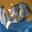

In [14]:
imgg = Image.open(io.BytesIO(ima[0]))
imgg

# Preparing the dataset

In [15]:
class ImageNetDataset(Dataset):
  """
  Converts image contents into a PyTorch Dataset with standard ImageNet preprocessing.
  """
  def __init__(self, contents):
    self.contents = contents

  def __len__(self):
    
    return len(self.contents)

  def __getitem__(self, index):
    return self._preprocess(self.contents[index])

  def _preprocess(self, content):
    """
    Preprocesses the input image content using standard ImageNet normalization.
    
    See https://pytorch.org/docs/stable/torchvision/models.html.
    """
    image = Image.open(io.BytesIO(content))
    transform = transforms.Compose([
      transforms.Resize(256),                         ### Smaller lenght is convertd to 256 
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

# Creating a Prediction Function

In [16]:
def imagenet_model_udf(model):
  """
  Wraps an ImageNet model into a Pandas UDF that makes predictions.
  
  You might consider the following customizations for your own use case:
    - Tune DataLoader's batch_size and num_workers for better performance.
    - Use GPU for acceleration.
    - Change prediction types.
  """
  model.eval()
  def predict(content_series_iter : pd.Series) -> pd.DataFrame:
    # model = model_fn() # Once per Map
    # model.eval()      # Once Per Map ,model file read from memory
    for content_series in content_series_iter:                                                    #Iterates overall all Images 
      dataset = ImageNetDataset(list(content_series))                                           
      loader = DataLoader(dataset, batch_size=64) 
      with torch.no_grad():
        for image_batch in loader:
          predictions = model(image_batch).numpy()                                                # Predictions for all 1000 classes of Mobilenetv2 Training Dataset
          predicted_labels = [x[0] for x in decode_predictions(predictions, top=1)]                       
          yield pd.DataFrame(predicted_labels)
    
        
  return_type = "class: string, desc: string, score:float"
  # return_type = "class: string"                                         # SCALAR_ITER implies the function accepts list/array of scalar values as input.
  return pandas_udf(predict,return_type, PandasUDFType.SCALAR_ITER)   
  # return pandas_udf(return_type, PandasUDFType.SCALAR_ITER)(predict)   
  
  #Returns a Predict function object as the final user defined function object.
  #Iterates over an Image: A sequence of bytes represented as a 2D array. 
  #Scalar is a series of bytes.    

# Mobile Net V2

In [54]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet_v2_udf = imagenet_model_udf(mobilenet)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [55]:
predictions = df.withColumn("prediction", mobilenet_v2_udf(col("content")))

In [59]:
predictions.select(col("label"),col("prediction")).show()

+----------+--------------------+
|     label|          prediction|
+----------+--------------------+
|       cat|{n02356798, fox_s...|
|      ship|{n04357314, sunsc...|
|      ship|{n02066245, grey_...|
|  airplane|{n03796401, movin...|
|      frog|{n07730033, cardo...|
|      frog|{n02090379, redbo...|
|automobile|{n03796401, movin...|
|      frog|{n03764736, milk_...|
|       cat|{n02096437, Dandi...|
|automobile|{n02979186, casse...|
|  airplane|{n02095314, wire-...|
|     truck|{n03796401, movin...|
|       dog|{n02091635, otter...|
|     horse|{n02488702, colob...|
|     truck|{n03796401, movin...|
|      ship|{n03958227, plast...|
|       dog|{n02089973, Engli...|
|     horse|{n02087046, toy_t...|
|      ship|{n03947888, pirat...|
|      frog|{n01644900, taile...|
+----------+--------------------+
only showing top 20 rows



In [60]:
predictions.select(col("label"),col("prediction")).collect()

[Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=9.141408920288086)),
 Row(label='ship', prediction=Row(class='n04357314', desc='sunscreen', score=8.71263313293457)),
 Row(label='ship', prediction=Row(class='n02066245', desc='grey_whale', score=12.407118797302246)),
 Row(label='airplane', prediction=Row(class='n03796401', desc='moving_van', score=7.9252800941467285)),
 Row(label='frog', prediction=Row(class='n07730033', desc='cardoon', score=10.015527725219727)),
 Row(label='frog', prediction=Row(class='n02090379', desc='redbone', score=8.068435668945312)),
 Row(label='automobile', prediction=Row(class='n03796401', desc='moving_van', score=11.113526344299316)),
 Row(label='frog', prediction=Row(class='n03764736', desc='milk_can', score=8.491353988647461)),
 Row(label='cat', prediction=Row(class='n02096437', desc='Dandie_Dinmont', score=8.274893760681152)),
 Row(label='automobile', prediction=Row(class='n02979186', desc='cassette_player', score=8.0800905227

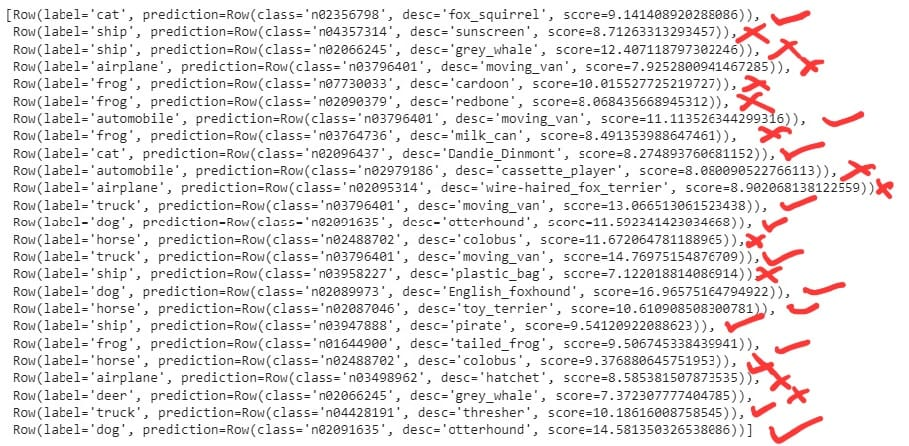

We see an accuracy of (12/25)

# Mobilenet V3 Large

In [68]:
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_udf = imagenet_model_udf(mobilenet_v3_large)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [69]:
predictions = df.withColumn("prediction", mobilenet_v3_udf(col("content")))
predictions.select(col("label"),col("prediction")).show()

+----------+--------------------+
|     label|          prediction|
+----------+--------------------+
|       cat|{n02089867, Walke...|
|      ship|{n03843555, oil_f...|
|      ship|{n03796401, movin...|
|  airplane|{n03796401, movin...|
|      frog|{n01739381, vine_...|
|      frog|{n02119022, red_f...|
|automobile|{n03796401, movin...|
|      frog|{n03764736, milk_...|
|       cat|{n02356798, fox_s...|
|automobile|{n02110627, affen...|
|  airplane|{n02095314, wire-...|
|     truck|{n03796401, movin...|
|       dog|{n02114712, red_w...|
|     horse|{n02488702, colob...|
|     truck|{n03796401, movin...|
|      ship|{n01773549, barn_...|
|       dog|{n02089973, Engli...|
|     horse|{n02389026, sorre...|
|      ship|{n03764736, milk_...|
|      frog|{n01688243, frill...|
+----------+--------------------+
only showing top 20 rows



In [70]:
predictions.select(col("label"),col("prediction")).collect()

[Row(label='cat', prediction=Row(class='n02089867', desc='Walker_hound', score=6.02200174331665)),
 Row(label='ship', prediction=Row(class='n03843555', desc='oil_filter', score=7.937060356140137)),
 Row(label='ship', prediction=Row(class='n03796401', desc='moving_van', score=9.402812004089355)),
 Row(label='airplane', prediction=Row(class='n03796401', desc='moving_van', score=6.679109573364258)),
 Row(label='frog', prediction=Row(class='n01739381', desc='vine_snake', score=7.4210896492004395)),
 Row(label='frog', prediction=Row(class='n02119022', desc='red_fox', score=7.749725341796875)),
 Row(label='automobile', prediction=Row(class='n03796401', desc='moving_van', score=8.383187294006348)),
 Row(label='frog', prediction=Row(class='n03764736', desc='milk_can', score=8.827871322631836)),
 Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=7.2999587059021)),
 Row(label='automobile', prediction=Row(class='n02110627', desc='affenpinscher', score=7.254663467407227

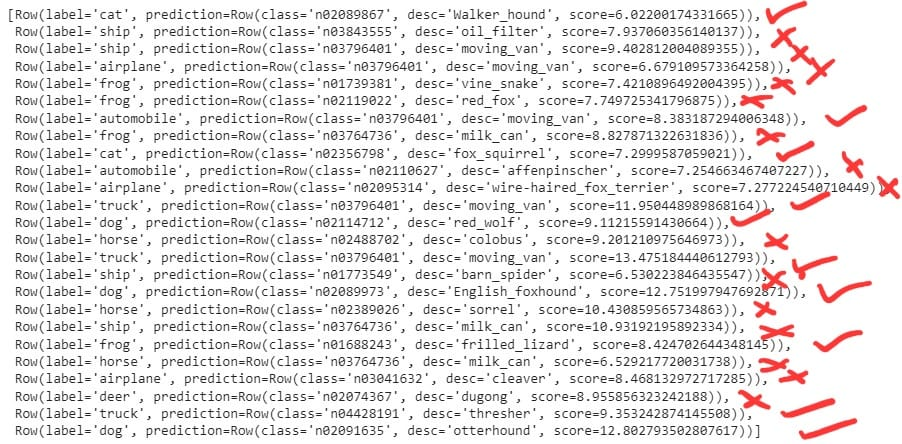

Accuracy = (10/25)

# GoogLeNet

In [71]:
googlenet = models.googlenet(pretrained=True)
googlenet_udf = imagenet_model_udf(googlenet)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [74]:
predictions = df.withColumn("prediction", googlenet_udf(col("content")))
predictions.select(col("label"),col("prediction")).show()

+----------+--------------------+
|     label|          prediction|
+----------+--------------------+
|       cat|{n02356798, fox_s...|
|      ship|{n03843555, oil_f...|
|      ship|{n02066245, grey_...|
|  airplane|{n04086273, revol...|
|      frog|{n02356798, fox_s...|
|      frog|{n02129165, lion,...|
|automobile|{n03843555, oil_f...|
|      frog|{n02356798, fox_s...|
|       cat|{n02356798, fox_s...|
|automobile|{n02979186, casse...|
|  airplane|{n02087046, toy_t...|
|     truck|{n03796401, movin...|
|       dog|{n02089973, Engli...|
|     horse|{n02447366, badge...|
|     truck|{n03796401, movin...|
|      ship|{n02074367, dugon...|
|       dog|{n02089973, Engli...|
|     horse|{n02087046, toy_t...|
|      ship|{n03764736, milk_...|
|      frog|{n02119789, kit_f...|
+----------+--------------------+
only showing top 20 rows



In [75]:
predictions.select(col("label"),col("prediction")).collect()

[Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=5.795327186584473)),
 Row(label='ship', prediction=Row(class='n03843555', desc='oil_filter', score=4.619577407836914)),
 Row(label='ship', prediction=Row(class='n02066245', desc='grey_whale', score=7.945838451385498)),
 Row(label='airplane', prediction=Row(class='n04086273', desc='revolver', score=5.15819787979126)),
 Row(label='frog', prediction=Row(class='n02356798', desc='fox_squirrel', score=5.566051959991455)),
 Row(label='frog', prediction=Row(class='n02129165', desc='lion', score=8.27585506439209)),
 Row(label='automobile', prediction=Row(class='n03843555', desc='oil_filter', score=6.267970561981201)),
 Row(label='frog', prediction=Row(class='n02356798', desc='fox_squirrel', score=8.244523048400879)),
 Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=5.805010795593262)),
 Row(label='automobile', prediction=Row(class='n02979186', desc='cassette_player', score=6.305727958679

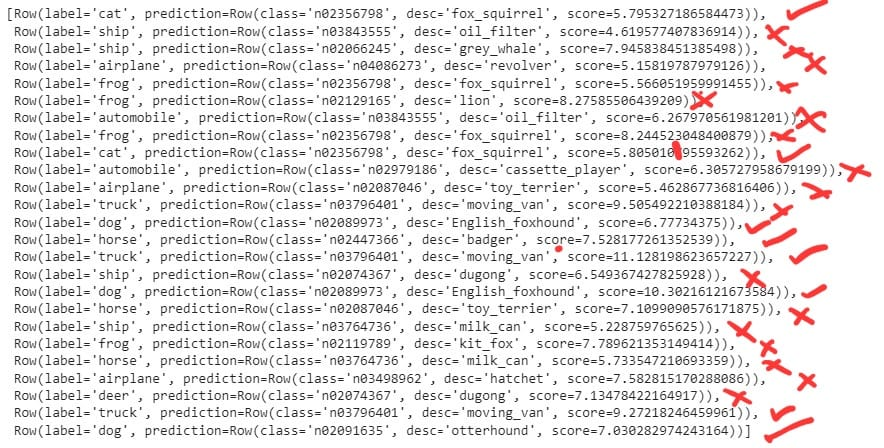

Accuracy = (8/25)

# Efficient Net

In [79]:
efficientnet_b7 = models.efficientnet_b7(pretrained=True)
efficientnet_udf = imagenet_model_udf(efficientnet_b7)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [80]:
predictions = df.withColumn("prediction", efficientnet_udf(col("content")))
predictions.select(col("label"),col("prediction")).show()

+----------+--------------------+
|     label|          prediction|
+----------+--------------------+
|       cat|{n02356798, fox_s...|
|      ship|{n04273569, speed...|
|      ship|{n04347754, subma...|
|  airplane|{n01704323, trice...|
|      frog|{n02277742, ringl...|
|      frog|{n01990800, isopo...|
|automobile|{n04086273, revol...|
|      frog|{n07716358, zucch...|
|       cat|{n02356798, fox_s...|
|automobile|{n07248320, book_...|
|  airplane|{n02087046, toy_t...|
|     truck|{n03796401, movin...|
|       dog|{n02090622, borzo...|
|     horse|{n02415577, bigho...|
|     truck|{n03417042, garba...|
|      ship|{n01873310, platy...|
|       dog|{n02101388, Britt...|
|     horse|{n02389026, sorre...|
|      ship|{n03947888, pirat...|
|      frog|{n02117135, hyena...|
+----------+--------------------+
only showing top 20 rows



In [81]:
predictions.select(col("label"),col("prediction")).collect()

[Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=7.613726615905762)),
 Row(label='ship', prediction=Row(class='n04273569', desc='speedboat', score=7.305118560791016)),
 Row(label='ship', prediction=Row(class='n04347754', desc='submarine', score=8.240005493164062)),
 Row(label='airplane', prediction=Row(class='n01704323', desc='triceratops', score=7.127346038818359)),
 Row(label='frog', prediction=Row(class='n02277742', desc='ringlet', score=8.602625846862793)),
 Row(label='frog', prediction=Row(class='n01990800', desc='isopod', score=6.037317752838135)),
 Row(label='automobile', prediction=Row(class='n04086273', desc='revolver', score=6.344356060028076)),
 Row(label='frog', prediction=Row(class='n07716358', desc='zucchini', score=5.680548191070557)),
 Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=6.407613754272461)),
 Row(label='automobile', prediction=Row(class='n07248320', desc='book_jacket', score=5.22442626953125)),
 Row

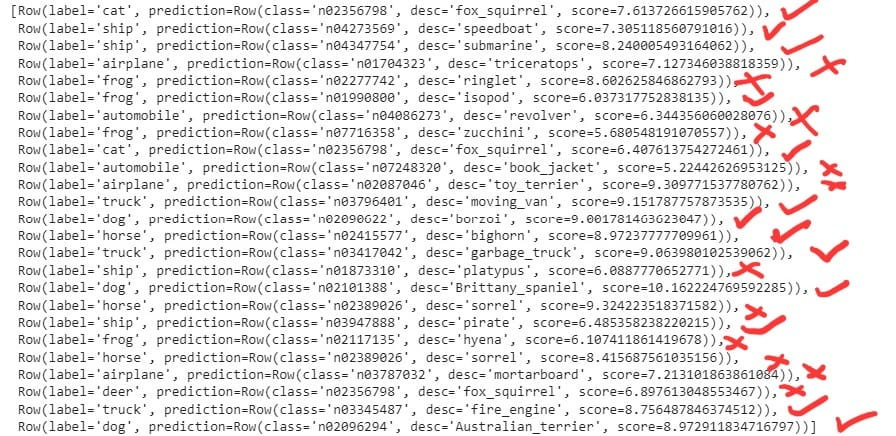

Accuracy = (13/25)

# VGG 16

In [17]:
vgg16 = models.vgg16(pretrained=True)
vgg16_udf = imagenet_model_udf(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [18]:
predictions = df.withColumn("prediction", vgg16_udf(col("content")))
predictions.select(col("label"),col("prediction")).show()

+----------+--------------------+
|     label|          prediction|
+----------+--------------------+
|       cat|{n02356798, fox_s...|
|      ship|{n02951585, can_o...|
|      ship|{n04612504, yawl,...|
|  airplane|{n04612504, yawl,...|
|      frog|{n02480495, orang...|
|      frog|{n02129165, lion,...|
|automobile|{n04285008, sport...|
|      frog|{n01688243, frill...|
|       cat|{n02356798, fox_s...|
|automobile|{n02979186, casse...|
|  airplane|{n02120079, Arcti...|
|     truck|{n03796401, movin...|
|       dog|{n02120505, grey_...|
|     horse|{n02488702, colob...|
|     truck|{n03796401, movin...|
|      ship|{n02606052, rock_...|
|       dog|{n02089973, Engli...|
|     horse|{n02090379, redbo...|
|      ship|{n03095699, conta...|
|      frog|{n01644900, taile...|
+----------+--------------------+
only showing top 20 rows



In [19]:
predictions.select(col("label"),col("prediction")).collect()

[Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=7.2859416007995605)),
 Row(label='ship', prediction=Row(class='n02951585', desc='can_opener', score=8.167214393615723)),
 Row(label='ship', prediction=Row(class='n04612504', desc='yawl', score=11.748790740966797)),
 Row(label='airplane', prediction=Row(class='n04612504', desc='yawl', score=7.781682014465332)),
 Row(label='frog', prediction=Row(class='n02480495', desc='orangutan', score=8.986248970031738)),
 Row(label='frog', prediction=Row(class='n02129165', desc='lion', score=7.827730655670166)),
 Row(label='automobile', prediction=Row(class='n04285008', desc='sports_car', score=9.598467826843262)),
 Row(label='frog', prediction=Row(class='n01688243', desc='frilled_lizard', score=6.415443420410156)),
 Row(label='cat', prediction=Row(class='n02356798', desc='fox_squirrel', score=9.725042343139648)),
 Row(label='automobile', prediction=Row(class='n02979186', desc='cassette_player', score=8.058330535888672)),


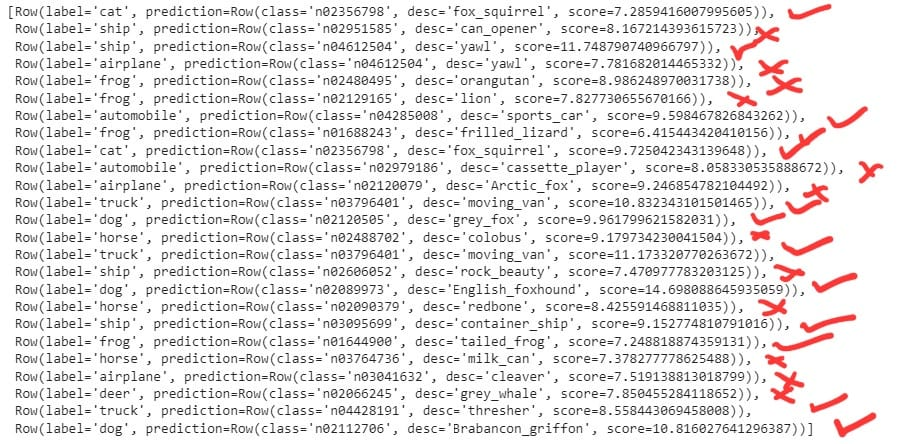

Accuracy = (13/25)